In [44]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from umap import UMAP


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [45]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/SexSmallBrain_ukb_without_residualization.csv"
label = "Sex"
max_iter = 2000
cv = 3

In [46]:
participants = pd.read_csv(participants_file, index_col=0)


In [47]:
participants = participants[participants.isBigBrain==0]

In [48]:
participants = participants[["Sex", "BrainVolumeFreeSurfer_mm3"]]

In [49]:
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return np.argsort((points-point)**2)[:10]

In [50]:
participants

,Sex,BrainVolumeFreeSurfer_mm3
participant_id,,
sub-1188492,0,997615.0
sub-2348409,0,1002614.0
sub-2214448,1,1012144.0
sub-5790117,0,1007438.0
sub-3794733,0,964232.0
...,...,...
sub-1734788,0,1029931.0
sub-1673986,0,1000852.0
sub-5224110,0,997299.0


In [51]:
females = participants[participants.Sex==0].copy()
males = participants[participants.Sex==1].copy()

females["chosen"] = 0
for one_male in males.iloc[:,1]:
    chosen_rows = closest_point(one_male, females.iloc[:,1])
    for chosen_row in chosen_rows:
        if females.iloc[chosen_row, 2] == 0:
            females.iloc[chosen_row, 2] = 1
            break

participants = pd.concat([males, females[females.chosen==1][["Sex", "BrainVolumeFreeSurfer_mm3"]]])

In [52]:
# participants[participants.Sex==0]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [53]:
# participants[participants.Sex==1]["BrainVolumeFreeSurfer_mm3"].hist(bins=100)

In [54]:
participants = participants[[label]].dropna()

array([[<Axes: title={'center': 'Sex'}>]], dtype=object)

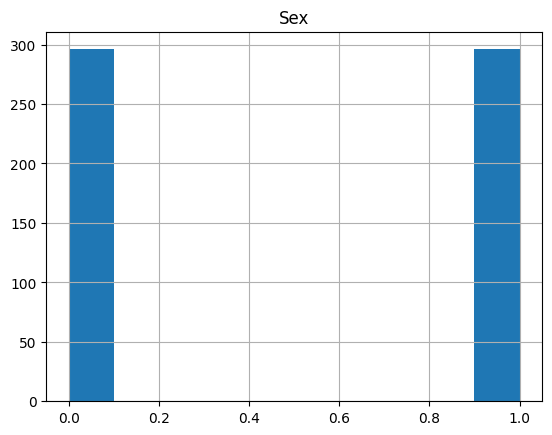

In [55]:
participants.hist()

In [56]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [57]:
model_paths = get_model_paths(path_champollion)

In [58]:
model_paths = [m for m in model_paths if "SFinf-BROCA-SPeCinf_right" in m ]

In [59]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    df2 = X.copy()

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y, df2)
    results = model.fit()
    ypred = results.predict(df2)
    f_value = results.fvalue
    p_value = results.f_pvalue
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path), merged, ypred

In [60]:
results = []
for model_path in model_paths:
    result, merged, ypred = compute(model_path)
    results.append(result)

Treating S.F.inf.-BROCA-S.Pe.C.inf._right: SFinf-BROCA-SPeCinf_right/12-25-50_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinf-BROCA-SPeCinf_right/12-25-50_1
2.0967100658746842


In [61]:
merged.insert(0, "ypred", ypred)

In [62]:
merged

,ypred,Sex,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
sub-2214448,1.386592,1,39.950733,66.746750,18.385942,-5.444563,-38.363823,26.628136,-21.786930,-41.806324,...,35.048283,95.518300,47.053960,-0.849994,49.980186,-4.459712,19.253105,-0.352856,44.293915,-29.695124
sub-1045691,0.822528,1,28.015203,54.324337,-19.283165,-3.175682,-94.038430,-9.439279,41.486958,10.327617,...,70.739460,161.036820,17.262531,34.722378,9.238580,-48.034145,-4.609680,-31.117113,27.772083,27.792343
sub-5365179,0.789071,1,47.605800,52.722515,-4.373391,-4.238018,-73.717770,16.876738,18.528194,-40.229004,...,4.155452,145.305860,48.444744,8.381267,44.330284,-23.359262,38.349224,-7.084336,32.334470,-5.191298
sub-4539455,0.843035,1,-59.900066,-41.178024,-11.942431,10.404506,-22.031400,-17.535376,-52.137306,0.238173,...,-17.633215,77.916890,13.872234,-33.056410,-27.314777,-0.313859,1.367200,41.563423,33.679184,-17.393652
sub-2641978,0.767846,1,2.187617,14.977101,-19.891367,-15.754981,-27.369951,-12.706059,-53.955956,5.847837,...,66.319020,112.946014,12.574077,26.295055,-3.048211,-37.489340,-9.262852,-8.282202,39.976303,-5.497882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-3529016,0.293817,0,7.165029,27.779678,22.563050,-7.052220,-22.825500,-37.109444,7.592823,-25.286860,...,2.740996,120.552574,78.811730,36.950302,15.152639,-37.623170,7.026593,-29.755114,40.000008,6.510882
sub-2666797,0.496594,0,2.175431,16.860802,-9.408803,7.621235,-33.210552,6.743974,-46.585278,3.334718,...,16.162040,68.931040,21.422104,-30.567562,-13.664957,12.784010,-2.978613,7.187579,21.961107,-35.596313
sub-5177527,0.079638,0,-27.016197,11.185370,37.523796,-6.004568,-18.714127,-13.440290,5.413888,-18.385720,...,-8.068265,75.951530,124.523056,37.331913,29.241040,-48.896896,3.435305,-9.557617,62.782387,38.089350
sub-5729360,0.221361,0,-69.707210,7.824608,19.615246,-31.338984,48.880980,26.557072,29.501343,-14.101874,...,-7.599153,47.657917,-20.567516,57.398365,27.548810,-1.983362,6.958013,-13.357493,-12.356679,48.279682


In [71]:
def compute_umap(df, n_neighbors=5, n_components=2):
    # apply umap
    reducer = UMAP(n_neighbors=n_neighbors, n_components=n_components)
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [72]:
merged[merged.ypred < 0.5].iloc[:,2:]

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
sub-2951229,-38.549490,-4.463937,-36.163006,-3.340569,-53.571728,6.225456,-11.238396,46.647310,-5.059414,24.004402,...,38.798035,99.213560,-29.910246,28.264097,1.298029,-35.772087,-16.845133,47.172140,34.293438,-14.749431
sub-5093461,-16.384480,-10.404963,-36.721250,0.889265,-59.641630,-25.245749,-5.042491,13.227574,-20.793156,-10.952958,...,-2.658217,148.547580,45.964110,42.428596,14.842465,-63.574436,22.198246,45.525110,56.241127,15.418695
sub-3976526,-17.614357,-1.177255,1.972764,31.835830,-23.267017,-42.660960,-45.257835,23.876482,17.464500,-46.277634,...,17.620424,94.676770,6.703483,0.947546,-32.921814,9.887152,-16.601927,34.482086,32.218086,-77.729560
sub-3497660,-39.444702,14.048905,-23.812712,-22.375494,-32.297920,-20.566805,37.913567,-8.005681,-60.005370,-15.320390,...,-18.722128,145.746770,10.940373,38.724453,-7.185931,-28.475960,34.099762,-7.861408,-7.983581,45.834373
sub-1575966,-91.054060,3.737599,-25.954565,-34.096973,-25.549051,20.583843,-5.058522,-4.610523,-10.695074,58.784412,...,-11.332276,81.701950,-4.844423,12.310773,18.629862,-33.066814,27.337675,48.141018,8.594964,34.317944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-3529016,7.165029,27.779678,22.563050,-7.052220,-22.825500,-37.109444,7.592823,-25.286860,-21.531202,-65.376680,...,2.740996,120.552574,78.811730,36.950302,15.152639,-37.623170,7.026593,-29.755114,40.000008,6.510882
sub-2666797,2.175431,16.860802,-9.408803,7.621235,-33.210552,6.743974,-46.585278,3.334718,-19.527805,-31.151880,...,16.162040,68.931040,21.422104,-30.567562,-13.664957,12.784010,-2.978613,7.187579,21.961107,-35.596313
sub-5177527,-27.016197,11.185370,37.523796,-6.004568,-18.714127,-13.440290,5.413888,-18.385720,-7.658785,-16.840652,...,-8.068265,75.951530,124.523056,37.331913,29.241040,-48.896896,3.435305,-9.557617,62.782387,38.089350
sub-5729360,-69.707210,7.824608,19.615246,-31.338984,48.880980,26.557072,29.501343,-14.101874,-51.684170,10.645788,...,-7.599153,47.657917,-20.567516,57.398365,27.548810,-1.983362,6.958013,-13.357493,-12.356679,48.279682


In [73]:
merged_inf_05 = merged[merged.ypred < 0.5]
visual_inf, _ = compute_umap(merged_inf_05.iloc[:,2:])

<Axes: xlabel='vis0', ylabel='vis1'>

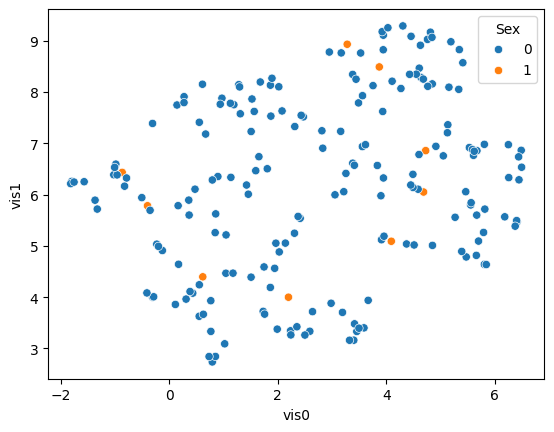

In [74]:
visual_df_inf = merged_inf_05[[label]].copy()
visual_df_inf[["vis0", "vis1"]] = visual_inf
sns.scatterplot(data=visual_df_inf, x="vis0", y="vis1", hue=label)

In [75]:
merged_sup_05 = merged[merged.ypred > 0.5]
visual_sup, _ = compute_umap(merged_sup_05.iloc[:,2:])

<Axes: xlabel='vis0', ylabel='vis1'>

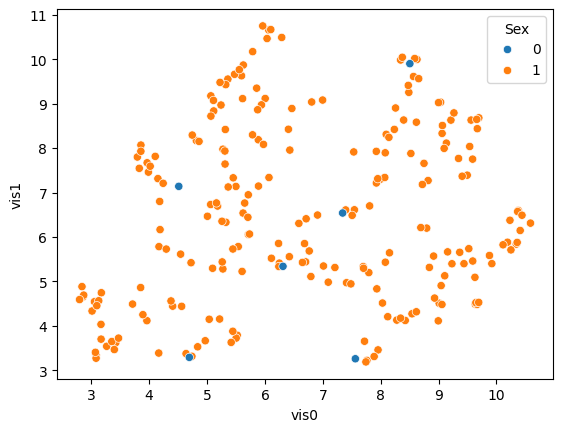

In [76]:
visual_df_sup = merged_sup_05[[label]].copy()
visual_df_sup[["vis0", "vis1"]] = visual_sup
sns.scatterplot(data=visual_df_sup, x="vis0", y="vis1", hue=label)

In [77]:
visual, _ = compute_umap(merged.iloc[:,2:])

<Axes: xlabel='vis0', ylabel='vis1'>

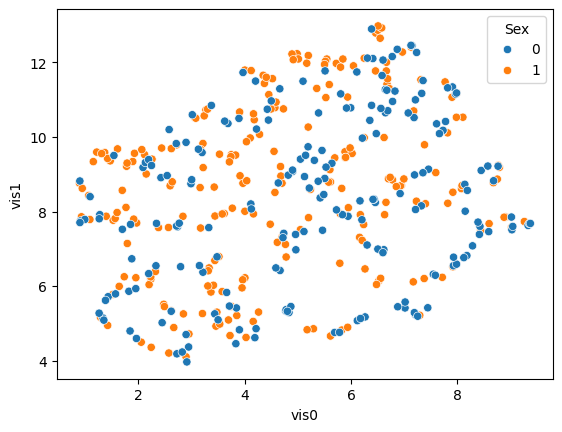

In [78]:
visual_df = merged[[label]].copy()
visual_df[["vis0", "vis1"]] = visual
sns.scatterplot(data=visual_df, x="vis0", y="vis1", hue=label)